In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [4]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from scipy.stats import norm, skew
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
SUBMISSION = False

## Data Research

In [6]:
data = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

In [7]:
data.shape

(1460, 81)

In [8]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [9]:
data.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu',
       'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars',
       'GarageArea', 'GarageQual', 'GarageCond', 'Pav

In [10]:
Categorical = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
               'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Numerical = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
             'Bedroom', 'Kitchen', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']

In [11]:
# with open('/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt', encoding='utf8') as file:
#     print(file.read())

In [12]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

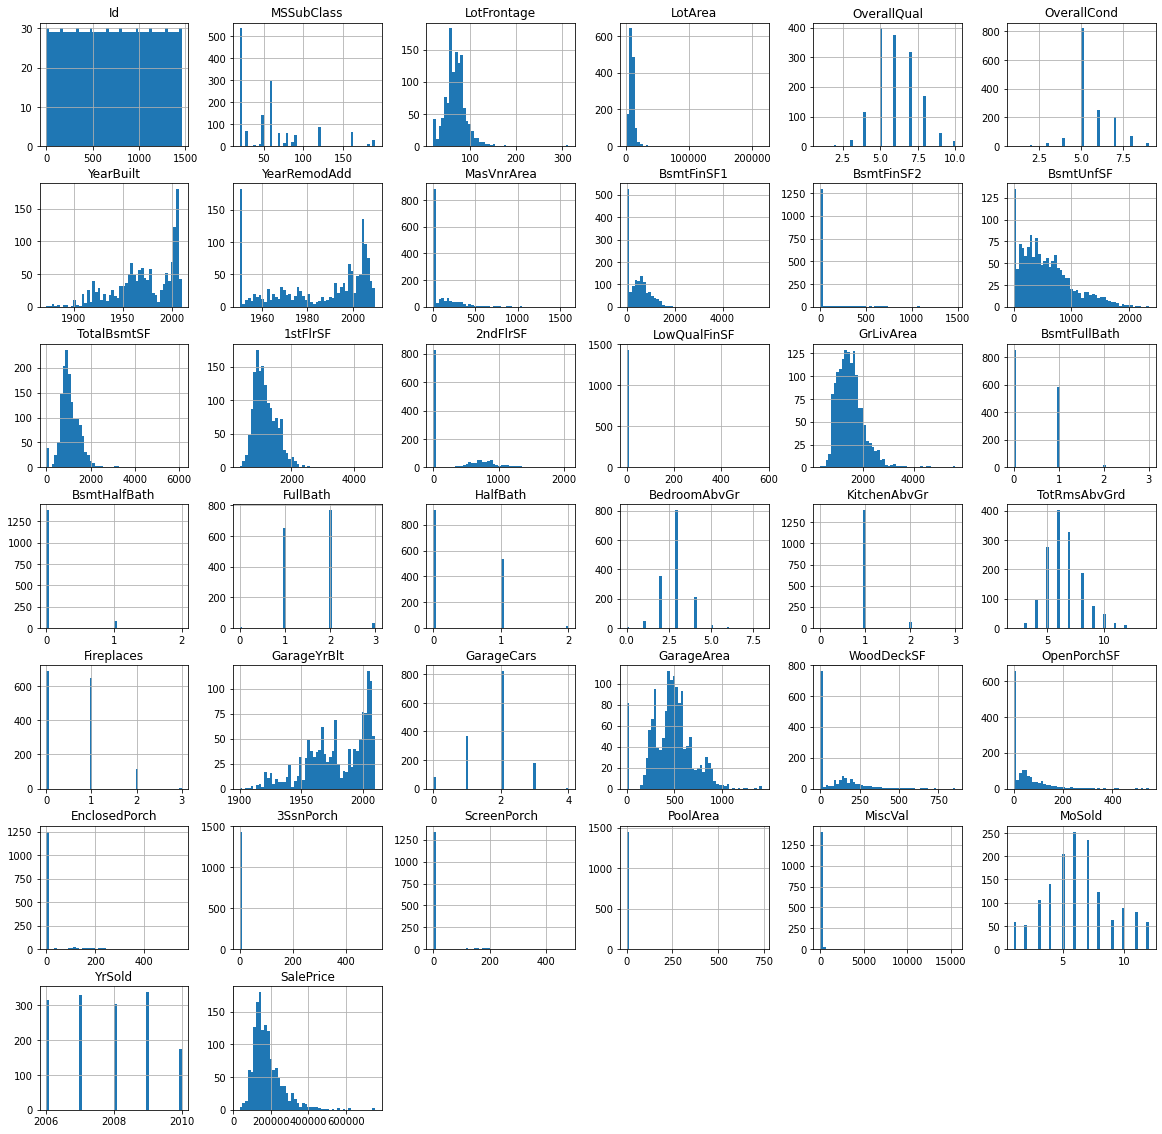

In [14]:
data.hist(bins=50,figsize=(20,20))
plt.show()

In [15]:
def drop_nan_columns(df, columns_to_drop = ['Alley', 'PoolQC', 'MiscFeature', 'Fence', 'FireplaceQu']):
    df = df.copy()
    df.drop(columns_to_drop, inplace=True, axis=1)
    return df

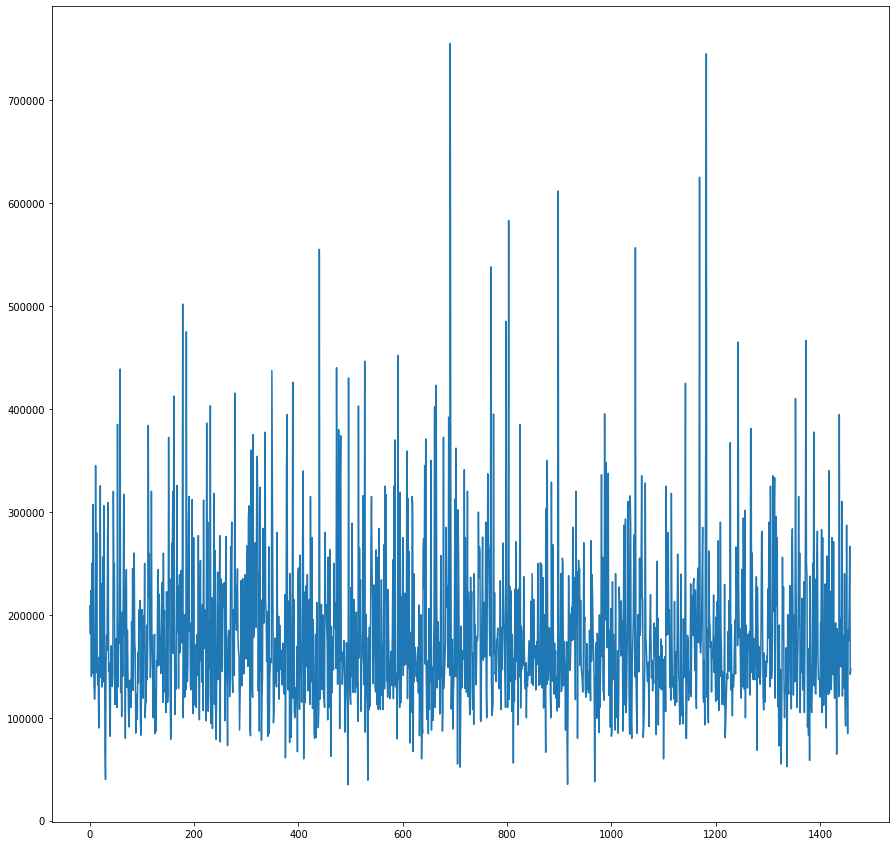

In [16]:
plt.figure(figsize=(15,15))
plt.plot(data['SalePrice'])

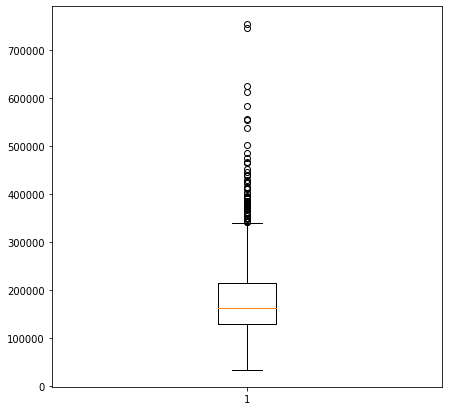

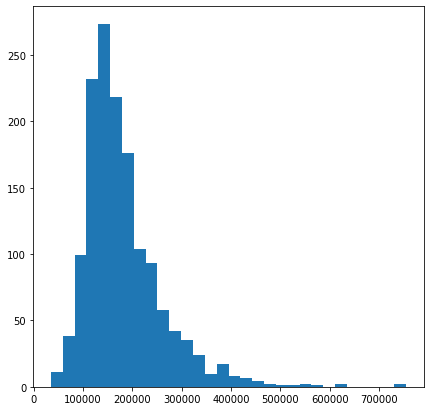

In [17]:
plt.figure(figsize=(7,7))
plt.boxplot(data['SalePrice'])
plt.show()
plt.figure(figsize=(7,7))
plt.hist(data['SalePrice'], bins=30)
plt.show()

In [18]:
def drop_outliers(df, quantile=.99):
    df = df.copy()
    df = df[df['SalePrice'] < df['SalePrice'].quantile(quantile)]
    return df

In [19]:
data.shape

(1460, 81)

we will fill missing values by 0 for numeric values and by 'None' for categorical

In [20]:
def fill_nan(X):
    X = X.copy()
    for feature in X.select_dtypes(['object']):
        X[feature] = X[feature].fillna('None')
    for feature in X.select_dtypes(['number']):
        X[feature] = X[feature].fillna(0)
    return X

In [21]:
data = fill_nan(data)
X_train = data.drop('SalePrice', axis=1)
y = data['SalePrice']

### Model evaluation


let's define a base function to evaluate our models

In [22]:
def model_score(X, y, model=XGBRegressor(n_estimators=1000), cv=5):
    X = X.copy()
    for feature in X.select_dtypes(['object']):
        X[feature], _ = X[feature].factorize()
    # we use log y, because competition loss is RMSLE
    log_y = np.log(y)
    score = cross_val_score(model, X, log_y, cv=cv, scoring='neg_mean_squared_error')
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score    

In [23]:
print(f'Base model RMSE = {model_score(X_train, y)}')

Base model RMSE = 0.14119587309512702


### Feature importance

In [24]:
def feature_estimate(X, y):
    X = X.copy()
    for col in X.select_dtypes(['object']):
        X[col], _ = X[col].factorize()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi = mutual_info_regression(X, y,  )
    mi = pd.Series(mi, index=X.columns)
    return mi

In [25]:
mi_score = feature_estimate(X_train, y).sort_values(ascending=False)

(array([34., 13.,  9.,  8.,  5.,  4.,  4.,  0.,  2.,  1.]),
 array([0.        , 0.05595856, 0.11191711, 0.16787567, 0.22383423,
        0.27979278, 0.33575134, 0.3917099 , 0.44766845, 0.50362701,
        0.55958557]),
 <BarContainer object of 10 artists>)

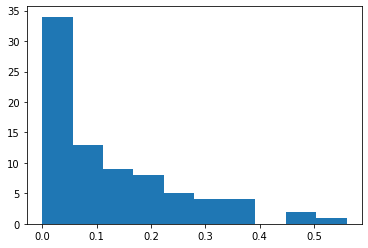

In [26]:
plt.hist(mi_score, bins=10)

In [27]:
mi_score

OverallQual     0.559586
Neighborhood    0.490866
GrLivArea       0.481090
TotalBsmtSF     0.368091
GarageArea      0.365495
                  ...   
MiscFeature     0.000000
MoSold          0.000000
YrSold          0.000000
LandSlope       0.000000
Id              0.000000
Length: 80, dtype: float64

In [28]:
# drop uninformation features
X_train = X_train.loc[:, mi_score > 0.0]
X_train.shape

(1460, 74)

## clean data

In [29]:
# # compare this with the data description
# for column in filter(lambda x: x in Categorical, X_train.columns):
#     print(column)
#     print(X_train[column].unique())
#     print()

In [30]:
def clean(df):
    df = df.copy()
    # fix the typos
    df['Exterior2nd'] = df['Exterior2nd'].replace({'Brk Cmn': 'BrkComm'})
    # fill na values with the year the hous was building
    df['GarageYrBlt'] = df['GarageYrBlt'].where(df.GarageYrBlt == 0 , df.YearBuilt)
    
    return df

In [31]:
X_train = clean(X_train)

### process categorical data

In [32]:
def factorize_cat_features(X):
    X = X.copy()
    for feature in Categorical:
        if feature in X.columns:
            X[feature] = X[feature].astype('category').cat.codes
    return X

In [33]:
X_train = factorize_cat_features(X_train)

### Create features

In [34]:
X_train.var().sort_values()

Utilities       6.849315e-04
Street          4.095505e-03
KitchenAbvGr    4.854892e-02
BsmtHalfBath    5.700283e-02
CentralAir      6.087628e-02
                    ...     
GarageYrBlt     2.049313e+05
BsmtFinSF1      2.080255e+05
MiscVal         2.461381e+05
GrLivArea       2.761296e+05
LotArea         9.962565e+07
Length: 74, dtype: float64

In [191]:
def create_features_by_hands(df):
    new_df = pd.DataFrame()
    new_df["LivLotRatio"] = df.GrLivArea / df.LotArea
    new_df['MeanNbhdArea'] = df.groupby('Neighborhood')['GrLivArea'].transform('mean')
    new_df['MeanNbhdOverallQual'] = df.groupby('Neighborhood')['OverallQual'].transform('mean')
    new_df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    
    square_features = ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
                      '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                      '3SsnPorch', 'ScreenPorch', 'PoolArea']
    for column in square_features:
        if column in df.columns:
            new_df[column+'_sqrt'] = np.sqrt(df[column])
    return new_df

# also we could try use k-means cluster labels as a feature or we could use the distance of the observations to each cluster. 
    
    

##### PCA

In [192]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    n = pca.n_components_
    bins = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    plt.bar(bins, evr, )
    plt.xlabel="Component"
    plt.title="% Explained Variance"
    plt.show()


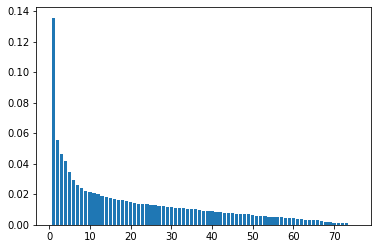

In [193]:
pca, X_pca, loadings = apply_pca(X_train)
plot_variance(pca)

In [194]:
def pca_components(df, features=["GarageArea","YearRemodAdd","TotalBsmtSF","GrLivArea",]):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca


## Pipeline

In [195]:
def create_features(df, train=True, mi_score=None):
    df = df.copy()
    # drop columns with a lot of empty values
    df = drop_nan_columns(df)
    # drop outliers
    if train:
        df = drop_outliers(df)
        df = df.reset_index()
    # fill Nan values
    df = fill_nan(df)
    
    if train:
        y = df['SalePrice']
        df = df.drop('SalePrice', axis=1)
        mi_score = feature_estimate(df, y).sort_values(ascending=False)
    # drop uninformation features
    df = df.loc[:, mi_score > 0.0]
    
    df = clean(df)
    df = factorize_cat_features(df)
    
    
    df = df.join(create_features_by_hands(df))
    df = df.join(pca_components(df)[['PC1', 'PC2']])
    
    if train:
        return df, y, mi_score
    
    return df

In [196]:
new_train_data, y, mi_score = create_features(data)

## build models

In [197]:
# Lasso
lasso = linear_model.Lasso()
# RandomForestRegressor
RFR = RandomForestRegressor(n_estimators = 1500, max_depth = 15,
                                         min_samples_split = 6, min_samples_leaf = 6)
# SVR
svr = SVR()

#### XGBRegressor

In [198]:
hyperparameter_grid = {
    'n_estimators': [100, 500, 900, 1000, 1500],
    'max_depth': [2, 3, 5, 6, 10, 15],
    'learning_rate': [0.001, 0.01, 0.1],
    'min_child_weight': [1, 2, 3, 4]
    }
# xgb = XGBRegressor()
# clf = GridSearchCV(xgb, hyperparameter_grid)
# clf.fit(X_train, y)

In [199]:
xgb_params = dict(
    max_depth=6,          
    learning_rate=0.01,   
    n_estimators=1000,     
    min_child_weight=1,   
    colsample_bytree=0.7, 
    subsample=0.7,      
    reg_alpha=0.5,      
    reg_lambda=1.0, 
    num_parallel_tree=1,
)

xgb = XGBRegressor(**xgb_params)

#### Catboost

In [200]:
GRIDSEARCH = False

if GRIDSEARCH:
    grid = {'iterations': [200, 500, 1000],
            'learning_rate': [0.03, 0.1],
            'depth': [2, 4, 6, 8],
            'l2_leaf_reg': [0.2, 0.5, 1, 3]}

    catboost = CatBoostRegressor(silent=True,)
    clf = GridSearchCV(catboost, grid)
    clf.fit(new_train_data, y)

    # catboost = CatBoostRegressor(iterations=3000, loss_function='RMSE', silent=True, learning_rate=0.001)
    score = model_score(new_train_data, y, clf)
    print('Total result on train set =', score)

In [201]:
catboost = CatBoostRegressor(iterations=1000, silent=True,)

#### GradientBoostingRegressor

In [202]:
gbr = GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.01,
                                              max_depth = 5, min_samples_split = 12, min_samples_leaf = 16,
                                              loss = "huber", max_features = "sqrt")

#### LGBMRegressor

In [203]:
lgbm_params = {
    'colsample_bytree': [0.4, 0.5,0.6,0.9,1],
    'learning_rate': [0.01, 0.1, 0.5,1],
    'n_estimators': [100, 200, 500, 1000]}

from lightgbm import LGBMRegressor
# lgbm = LGBMRegressor(colsample_bytree = 0.4,
#                     learning_rate = 0.01,
#                     n_estimators = 1000)

lgbm = LGBMRegressor(num_leaves = 6, 
                                   learning_rate = 0.01, n_estimators = 7500, max_bin = 200,
                                   random_state = 11, silent = True)

if not SUBMISSION:
    print(model_score(new_train_data, y, lgbm))

0.12129038134778597


#### Check models

In [205]:
models = {'lasso': lasso, 'RandomForestRegressor': RFR, 'XGBoost Regressor': xgb, 'svr': svr, 
          'LGBMRegresso': lgbm, 'GradientBoostingRegressor': gbr, 'catboost': catboost}

X = new_train_data

if not SUBMISSION:
    for model in models:
        print(f'{model} RMSLE = {model_score(X, y, models[model])}')



lasso RMSLE = 0.1896562163701476
RandomForestRegressor RMSLE = 0.14130726485826844
XGBoost Regressor RMSLE = 0.11927202464637907
svr RMSLE = 0.190409549718149
LGBMRegresso RMSLE = 0.12129038134778597
GradientBoostingRegressor RMSLE = 0.1196507572298289
catboost RMSLE = 0.11620939895108622


#### StackingCVRegressor

In [206]:
SUBMISSION = True

In [207]:
stacked_xgb = make_pipeline(RobustScaler(),
                    StackingCVRegressor(regressors = (xgb, catboost, lgbm, svr, lasso, gbr, RFR),
                              meta_regressor = xgb, use_features_in_secondary = True))
if not SUBMISSION:
    score = model_score(new_train_data, y, stacked_xgb, cv=3)
    print('Total result on train set =', score)
    # Total result on train set = 0.11651954238102141

In [208]:
stacked_lgbm = make_pipeline(RobustScaler(),
                    StackingCVRegressor(regressors = (xgb, catboost, lgbm, svr, lasso, gbr, RFR),
                              meta_regressor = lgbm, use_features_in_secondary = True))
if not SUBMISSION:
    score = model_score(new_train_data, y, stacked_lgbm, cv=3)
    print('Total result on train set =', score)
    # Total result on train set = 0.11651954238102141

### check other models

## Test

In [209]:
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [210]:
test = create_features(test, False, mi_score)
X = new_train_data

In [211]:
X.shape, test.shape

((1445, 90), (1459, 90))

In [212]:
subm = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv', index_col='Id')

In [213]:
# model = CatBoostRegressor(iterations=4000, silent=True,)
model = stacked_lgbm

# y = y  # np.log1p()
y = np.log1p(y)
model.fit(X, y)
# subm['SalePrice'] = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15
# subm['SalePrice'] = model.predict(test) # np.expm1
subm['SalePrice'] = np.expm1(model.predict(test))

In [214]:
subm.to_csv('submission.csv')

In [215]:
subm

,SalePrice
Id,
1461,121924.959284
1462,159598.998770
1463,186435.463403
1464,193847.505905
1465,160018.641187
...,...
2915,70833.610614
2916,83282.625213
2917,159226.839475
